In [1]:
import pandas as pd 
import cv2, numpy as np
from scipy.stats import norm
from scipy.misc import imread
import re
import idx2numpy as idx
from copy import copy
import os
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, precision_score, recall_score
from sklearn.manifold import TSNE

# keras
np.random.seed(13)
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, Convolution1D, \
                         MaxPooling1D, Merge, Dropout, Input
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Dropout, Activation, Lambda, Layer # keras.layers.core 
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras import metrics

# logging
import logging
from importlib import reload
reload(logging)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using Theano backend.


In [2]:
rootpath = "../EgyptianHieroglyphDataset/MyTrainTest"
batch_size = 32 // 2 
        # TODO 32 is standard; decrease futher for small datasets; 
        # has to be divisible by num training rows; must be int and not float
original_dim = 75 * 50
intermediate_dim = 850
latent_dim = 10 # had it at 170 but Andrew didn't recommend it
epochs = 10 # 50
epsilon_std = 1.0
n_classes = 170

In [3]:
def get_data(tr_ts):
    """
    tr_ts: train or test as a string
    """
    if tr_ts == "train":
        try:
            x_train = np.load("../data/x_train.pkl")
            y_train = np.load("../data/y_train.pkl")
        except:
            logging.info("Pickle files not found. Creating data from png files.")
            x_train, y_train = get_tr_array_from_png()
            x_train.dump("../data/x_train.pkl")
            y_train.dump("../data/y_train.pkl")
        return x_train, y_train
    else:
        try:
            x_test = np.load("../data/x_test.pkl")
            y_test = np.load("../data/y_test.pkl")
        except:
            logging.info("Pickle files not found. Creating data from png files.")
            x_test, y_test = get_ts_array_from_png()
            x_test.dump("../data/x_test.pkl")
            y_test.dump("../data/y_test.pkl")
        return x_test, y_test          

In [4]:
def get_tr_array_from_png():
    """
    data description:
        Dataset is compiled by Morris Franken, complementary to the paper titeled "Automatic Egyptian \
        Hieroglyph Recognition by Retrieving Images as Texts" (ACM Conference on Multimedia, 2013).
    Shape of png file as rgb array:  (75, 50, 3)
    future work: too many caveats to fit model to generator for now; need to try and fix it
    """
    n_symbols = symbol_df.shape[0]
    batch_arrayfile = np.empty((0, original_dim))
    batch_label = np.empty((0, n_symbols))
    tr_rootpath = os.path.join(rootpath, "train")
    subdirs = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
    for subdirpath in subdirs:
        subdir = os.path.join(tr_rootpath, subdirpath)
        files = [x for x in os.listdir(subdir) if re.search(r"UNKNOWN|^\.", x) == None]
        for fpath in files:        
            pngfile = os.path.join(subdir, fpath)
            
            # get y
            label_txt = re.sub(r"^.*_(?P<symbol>.*)\.png$", "\g<symbol>", pngfile)
            cond = symbol_df["symbol"] == label_txt
            label_num = int(symbol_df.loc[cond, "symbol_num"])
            label = np_utils.to_categorical(label_num, n_symbols)
            batch_label = np.vstack([batch_label, label])  
            
            # get x
            arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
            arrayfile = np.reshape(arrayfile, original_dim) / 255.
            batch_arrayfile = np.vstack([batch_arrayfile, arrayfile])     
    return batch_arrayfile, batch_label

In [5]:
def get_ts_array_from_png():
    """
    data description:
        Dataset is compiled by Morris Franken, complementary to the paper titeled "Automatic Egyptian \
        Hieroglyph Recognition by Retrieving Images as Texts" (ACM Conference on Multimedia, 2013).
    Shape of png file as rgb array:  (75, 50, 3)
    future work: too many caveats to fit model to generator for now; need to try and fix it
    """
    n_symbols = symbol_df.shape[0]
    batch_arrayfile = np.empty((0, original_dim))
    batch_label = np.empty((0, n_symbols))
    ts_rootpath = os.path.join(rootpath, "test")
    files = [x for x in os.listdir(ts_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
    for fpath in files:
        pngfile = os.path.join(ts_rootpath, fpath)
            
        # get y
        label_txt = re.sub(r"^.*_(?P<symbol>.*)\.png$", "\g<symbol>", pngfile)
        try:
            cond = symbol_df["symbol"] == label_txt
            label_num = int(symbol_df.loc[cond, "symbol_num"])
            label = np_utils.to_categorical(label_num, n_symbols)
            batch_label = np.vstack([batch_label, label])
            
            # get x
            arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
            arrayfile = np.reshape(arrayfile, original_dim) / 255.
            batch_arrayfile = np.vstack([batch_arrayfile, arrayfile]) 
        except:
            logging.debug(label_txt + " not found in dictionary. Fix this!") 
    return batch_arrayfile, batch_label

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [7]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

### import data

In [8]:
# !pwd

In [9]:
tr_rootpath = os.path.join(rootpath, "train")
symbol_df = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
symbol_df = pd.DataFrame(sorted(symbol_df))
symbol_df.reset_index(inplace = True)
symbol_df.columns = ["symbol_num", "symbol"]
symbol_df.tail(1)

,symbol_num,symbol
169,169,Z7


In [10]:
x_train, y_train = get_data("train")

In [11]:
print(x_train.shape, y_train.shape)

(3584, 3750) (3584, 170)


In [12]:
x_test, y_test = get_data("test")

In [13]:
print(x_test.shape, y_test.shape)

(448, 3750) (448, 170)


### build vae

In [14]:
# TODO convolution, and then encode?

In [15]:
x = Input(batch_shape=(batch_size, original_dim), name = "input")
h = Dense(intermediate_dim, activation='relu', name = "encoder1")(x)
z_mean = Dense(latent_dim, name = "latent")(h)
z_log_var = Dense(latent_dim, name = "latent_var")(h)

In [16]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name = "lambda")([z_mean, z_log_var])

In [17]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [18]:
y = CustomVariationalLayer()([x, x_decoded_mean])

In [19]:
vae = Model(inputs=x, outputs=y)

In [20]:
# rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vae.compile(optimizer=adm, loss=None) # rmsprop 

/home/katharina/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  app.launch_new_instance()


### train vae

In [21]:
# train the VAE on MNIST digits
history_callback = vae.fit(x_train,
                           shuffle=True,
                           epochs=epochs,
                           batch_size=batch_size,
                           validation_data=(x_test, x_test))

# vae.fit_generator(tr_generator,
#         epochs=epochs,
#         steps_per_epoch = 100, 
#         validation_data=ts_generator, 
#         validation steps = 20)

Train on 3584 samples, validate on 448 samples
Epoch 1/10
3584/3584 [==============================] - 23s - loss: 2097.3727 - val_loss: 2149.1686
Epoch 2/10
3584/3584 [==============================] - 22s - loss: 2058.5758 - val_loss: 2168.0678
Epoch 3/10
3584/3584 [==============================] - 22s - loss: 2046.4633 - val_loss: 2141.6497
Epoch 4/10
3584/3584 [==============================] - 59s - loss: 2039.5353 - val_loss: 2126.0405
Epoch 5/10
3584/3584 [==============================] - 53s - loss: 2034.5784 - val_loss: 2125.0604
Epoch 6/10
3584/3584 [==============================] - 52s - loss: 2031.9612 - val_loss: 2122.1294
Epoch 7/10
3584/3584 [==============================] - 52s - loss: 2030.1031 - val_loss: 2120.2349
Epoch 8/10
3584/3584 [==============================] - 52s - loss: 2026.0621 - val_loss: 2112.7509
Epoch 9/10
3584/3584 [==============================] - 53s - loss: 2023.7579 - val_loss: 2111.3010
Epoch 10/10
3584/3584 [==============================

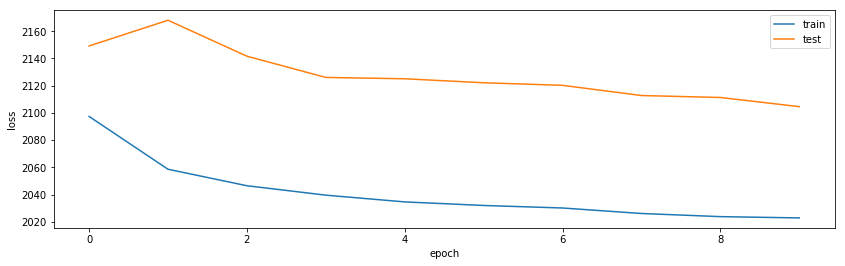

In [27]:
plt.figure(figsize = (14, 4))
xaxis = range(epochs)
plt.plot(xaxis, history_callback.history['loss'], label = "train")
plt.plot(xaxis, history_callback.history['val_loss'], label = "test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### get a separate model (the encoder) that outputs latent features

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(inputs=x, outputs=z_mean)

In [ ]:
encoder_wt = encoder.get_weights()

In [ ]:
print(encoder_wt[0].shape, encoder_wt[1].shape, encoder_wt[2].shape, encoder_wt[3].shape)

In [ ]:
encoder.summary()

In [ ]:
encoder.layers

### explore encoder result

In [ ]:
x_train_encoded = encoder.predict(x_train, batch_size=batch_size)
tsne = TSNE(n_components = 2)
x_train_tsne = tsne.fit_transform(x_train_encoded)

In [ ]:
print(x_train.shape, x_train_encoded.shape, x_train_tsne.shape)

In [ ]:
# img=mpimg.imread(os.path.join(rootpath, "test", "070000_M17.png"))
# plt.imshow(img, cmap='gray')

In [ ]:
y_train_cat = pd.Series(np.argmax(y_train, 1), name = "true")
plt.figure(figsize = (18, 8))
plt.title("Latent Space T-SNE")
kwargs = {'alpha': 0.7, 's': 40}

classes = set(symbol_df["symbol_num"])
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in y_train_cat]
    #kwargs['marker'] = r'$\diamondsuit$' # TODO customize marker shape. Do it in D3?
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
               for i, class_ in enumerate(classes)]
#     ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
#               fancybox=True, loc='center left')
    
plt.scatter(x_train_tsne[:, 0],
            x_train_tsne[:, 1],
            **kwargs)
plt.show()

In [ ]:
# TODO pickle encoder?

### build classifier based on latent features

In [ ]:
try:
    del clf
except:
    pass
finally:
    clf = Sequential()
    clf.add(encoder.layers[0])
    clf.add(encoder.layers[1])
    clf.add(encoder.layers[2])
    clf.set_weights(encoder_wt)
    
    for layer in clf.layers:
        layer.trainable = True # False
    
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm1'))
    clf.add(Dense(1875, activation='relu', name='clf1'))
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm2'))
    clf.add(Dropout(0.5))
    clf.add(Dense(900, activation='relu', name='clf2'))
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm3'))
    clf.add(Dropout(0.7))
    clf.add(Dense(n_classes, activation='softmax', name='predictions'))

In [ ]:
clf.summary()

In [ ]:
# compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # TODO slowly lower lr to 0.01 or something else
clf.compile(optimizer=sgd, loss='categorical_crossentropy')

### train classifier

In [ ]:
clf.fit(x_train, y_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test))

In [ ]:
# TODO  plot number of epochs (x axis) vs. accuracy (y axis)

### explore classifier performance

In [ ]:
test_pred = clf.predict(x_test, batch_size=batch_size)

In [ ]:
test_pred_cat = pd.Series(np.argmax(test_pred, 1), name = "pred")
y_test_cat = pd.Series(np.argmax(y_test, 1), name = "true")

In [ ]:
pd.crosstab(test_pred_cat, y_test_cat)

In [ ]:
for avg in ["micro", "macro"]:
    accuracy = accuracy_score(y_test_cat, test_pred_cat)
    precision = precision_score(y_test_cat, test_pred_cat, average = avg)
    recall = recall_score(y_test_cat, test_pred_cat, average = avg)
    f1 = f1_score(y_test_cat, test_pred_cat, average = avg)
    print(avg, "average: accuracy", format(accuracy, "6.4f"), \
          "precision", format(precision, "6.4f"), \
          "recall", format(recall, "6.4f"), \
          "f1", format(f1, "6.4f"))

### check data imbalance

In [ ]:
y_train_cat = pd.Series(np.argmax(y_train, 1), name = "true")
y_train_cat.value_counts()